In [1]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import math
import scienceplots
import matplotlib as mpl
from tqdm import tqdm
import optuna

In [2]:
SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED) 
random.seed(SEED) #通过不同的随机数生成器，使得随机数是可重复的
torch.backends.cudnn.deterministic = True

x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1) 
ytrain = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2+1) + 0.12*torch.randn(x.size())   # 这里是污染数据固定不变当成训练数据


In [3]:
class Net(torch.nn.Module):  # 定义神经网络模型“Net"，属于torch.nn.Module这一类
    def __init__(self, n_feature, n_hidden1, n_output, noise=0.1):#输入，隐藏，输出神经元数量
        super(Net, self).__init__()#这一行调用了父类的构造函数，用于初始化继承自父类的属性。
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层
        self.noise = noise
        
    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)+ self.noise
        x = self.predict(x)  # 前向传播过程
        return x
    
    def reset_parameters(self):
        self.hidden1.reset_parameters()
        self.predict.reset_parameters()
#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数

In [4]:
device = torch.device('cpu')
# 定义目标函数
def objective(trial):
    noise = trial.suggest_float('noise', 0, 9)
    net = Net(n_feature=1, n_hidden1=14, n_output=1, noise=noise).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
    loss_func = nn.MSELoss().to(device)
    NJnum = 10
    epoch = 15000
    train_losses = []
    
    for num in range(NJnum):
        seed = random.sample(range(1, 1000), 1)[0]#选择一个随机种子
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        net.reset_parameters()#每次实验前重置网络参数
        
        
        for t in range(epoch):
            prediction = net(x)
            loss = loss_func(prediction, ytrain)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)      
            optimizer.step()
        
        train_losses.append(loss.item()) # 记录本次训练的损失值
        
    train_loss = np.mean(train_losses) # 计算平均训练损失
    

    # Test phase
    seeds = random.sample(range(1, 1000), 10)
    test_losses = []
    
    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1)
        y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size())

        net.eval()
        with torch.no_grad():
            prediction_test = net(x_test)
            test_loss = loss_func(prediction_test, y_test)
            test_losses.append(test_loss.item())

    mean_test_loss = np.mean(test_losses)
    return mean_test_loss

In [5]:
# 运行优化
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# 获取最佳 sigma 值
best_noise = study.best_params["noise"]
print("Best noise:", best_noise)

[I 2024-07-07 22:26:06,906] A new study created in memory with name: no-name-60d920ad-cfbd-459d-ad37-c4a11a33dcc9
[I 2024-07-07 22:27:46,112] Trial 0 finished with value: 0.024906111415475607 and parameters: {'noise': 8.79608008416887}. Best is trial 0 with value: 0.024906111415475607.
[I 2024-07-07 22:29:27,057] Trial 1 finished with value: 0.02205376559868455 and parameters: {'noise': 8.58471813686956}. Best is trial 1 with value: 0.02205376559868455.
[I 2024-07-07 22:31:06,595] Trial 2 finished with value: 0.025760439038276673 and parameters: {'noise': 4.4013698238174666}. Best is trial 1 with value: 0.02205376559868455.
[I 2024-07-07 22:32:41,741] Trial 3 finished with value: 0.024443182349205016 and parameters: {'noise': 6.9667778994090055}. Best is trial 1 with value: 0.02205376559868455.
[I 2024-07-07 22:34:16,700] Trial 4 finished with value: 0.02608711048960686 and parameters: {'noise': 0.5420307855346981}. Best is trial 1 with value: 0.02205376559868455.
[I 2024-07-07 22:35:5

Best noise: 8.58471813686956


In [6]:
# 获取最佳 sigma 值
best_noise = study.best_params["noise"]
print(best_noise)

8.58471813686956


In [7]:
# 使用最佳参数重新训练模型
device = torch.device('cpu') 
net = Net(n_feature=1, n_hidden1=14, n_output=1, noise=best_noise).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
loss_func = torch.nn.MSELoss().to(device)

# Define training settings
NJnum = 10
epoch = 15000

# 定义数据
x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1)
ytrain = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2 / 10) + 1 / (x**2 + 1) + 0.12 * torch.randn(x.size())
# Define x_respond for response plotting
x_respond = torch.unsqueeze(torch.linspace(-2, 10, 300), dim=1)

# Initialize lists to store losses and responses
train_losses = []
responses = []

# Training loop with noisy data
for num in range(NJnum):
    seed = random.sample(range(1, 10000), 1)[0]
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    net.reset_parameters()
    
    # Training loop
    for _ in range(epoch):
        net.train()
        prediction = net(x)
        loss = loss_func(prediction, ytrain)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append the train loss
    train_losses.append(loss.item())

    # Calculate mean response for x_respond after training
    net.eval()
    with torch.no_grad():
        response = net(x_respond)
        responses.append(response.numpy())

# Calculate mean train loss
mean_train_loss = np.mean(train_losses)
# Calculate mean response across NJnum runs
mean_response = np.mean(responses, axis=0)

# Test phase
seeds = random.sample(range(1, 10000), 10)
test_losses = []

for seed in seeds:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1).to(device)
    y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size()).to(device)

    net.eval()
    with torch.no_grad():
        prediction_test = net(x_test)
        test_loss = loss_func(prediction_test, y_test)
        test_losses.append(test_loss.item())

mean_test_loss = np.mean(test_losses)

print("Best hyperparameter (sigma):",best_noise )
print("Mean Test Loss:", mean_test_loss)
print("Mean Train Loss:", mean_train_loss)

Best hyperparameter (sigma): 8.58471813686956
Mean Test Loss: 0.029230309836566448
Mean Train Loss: 0.0017282361397519708


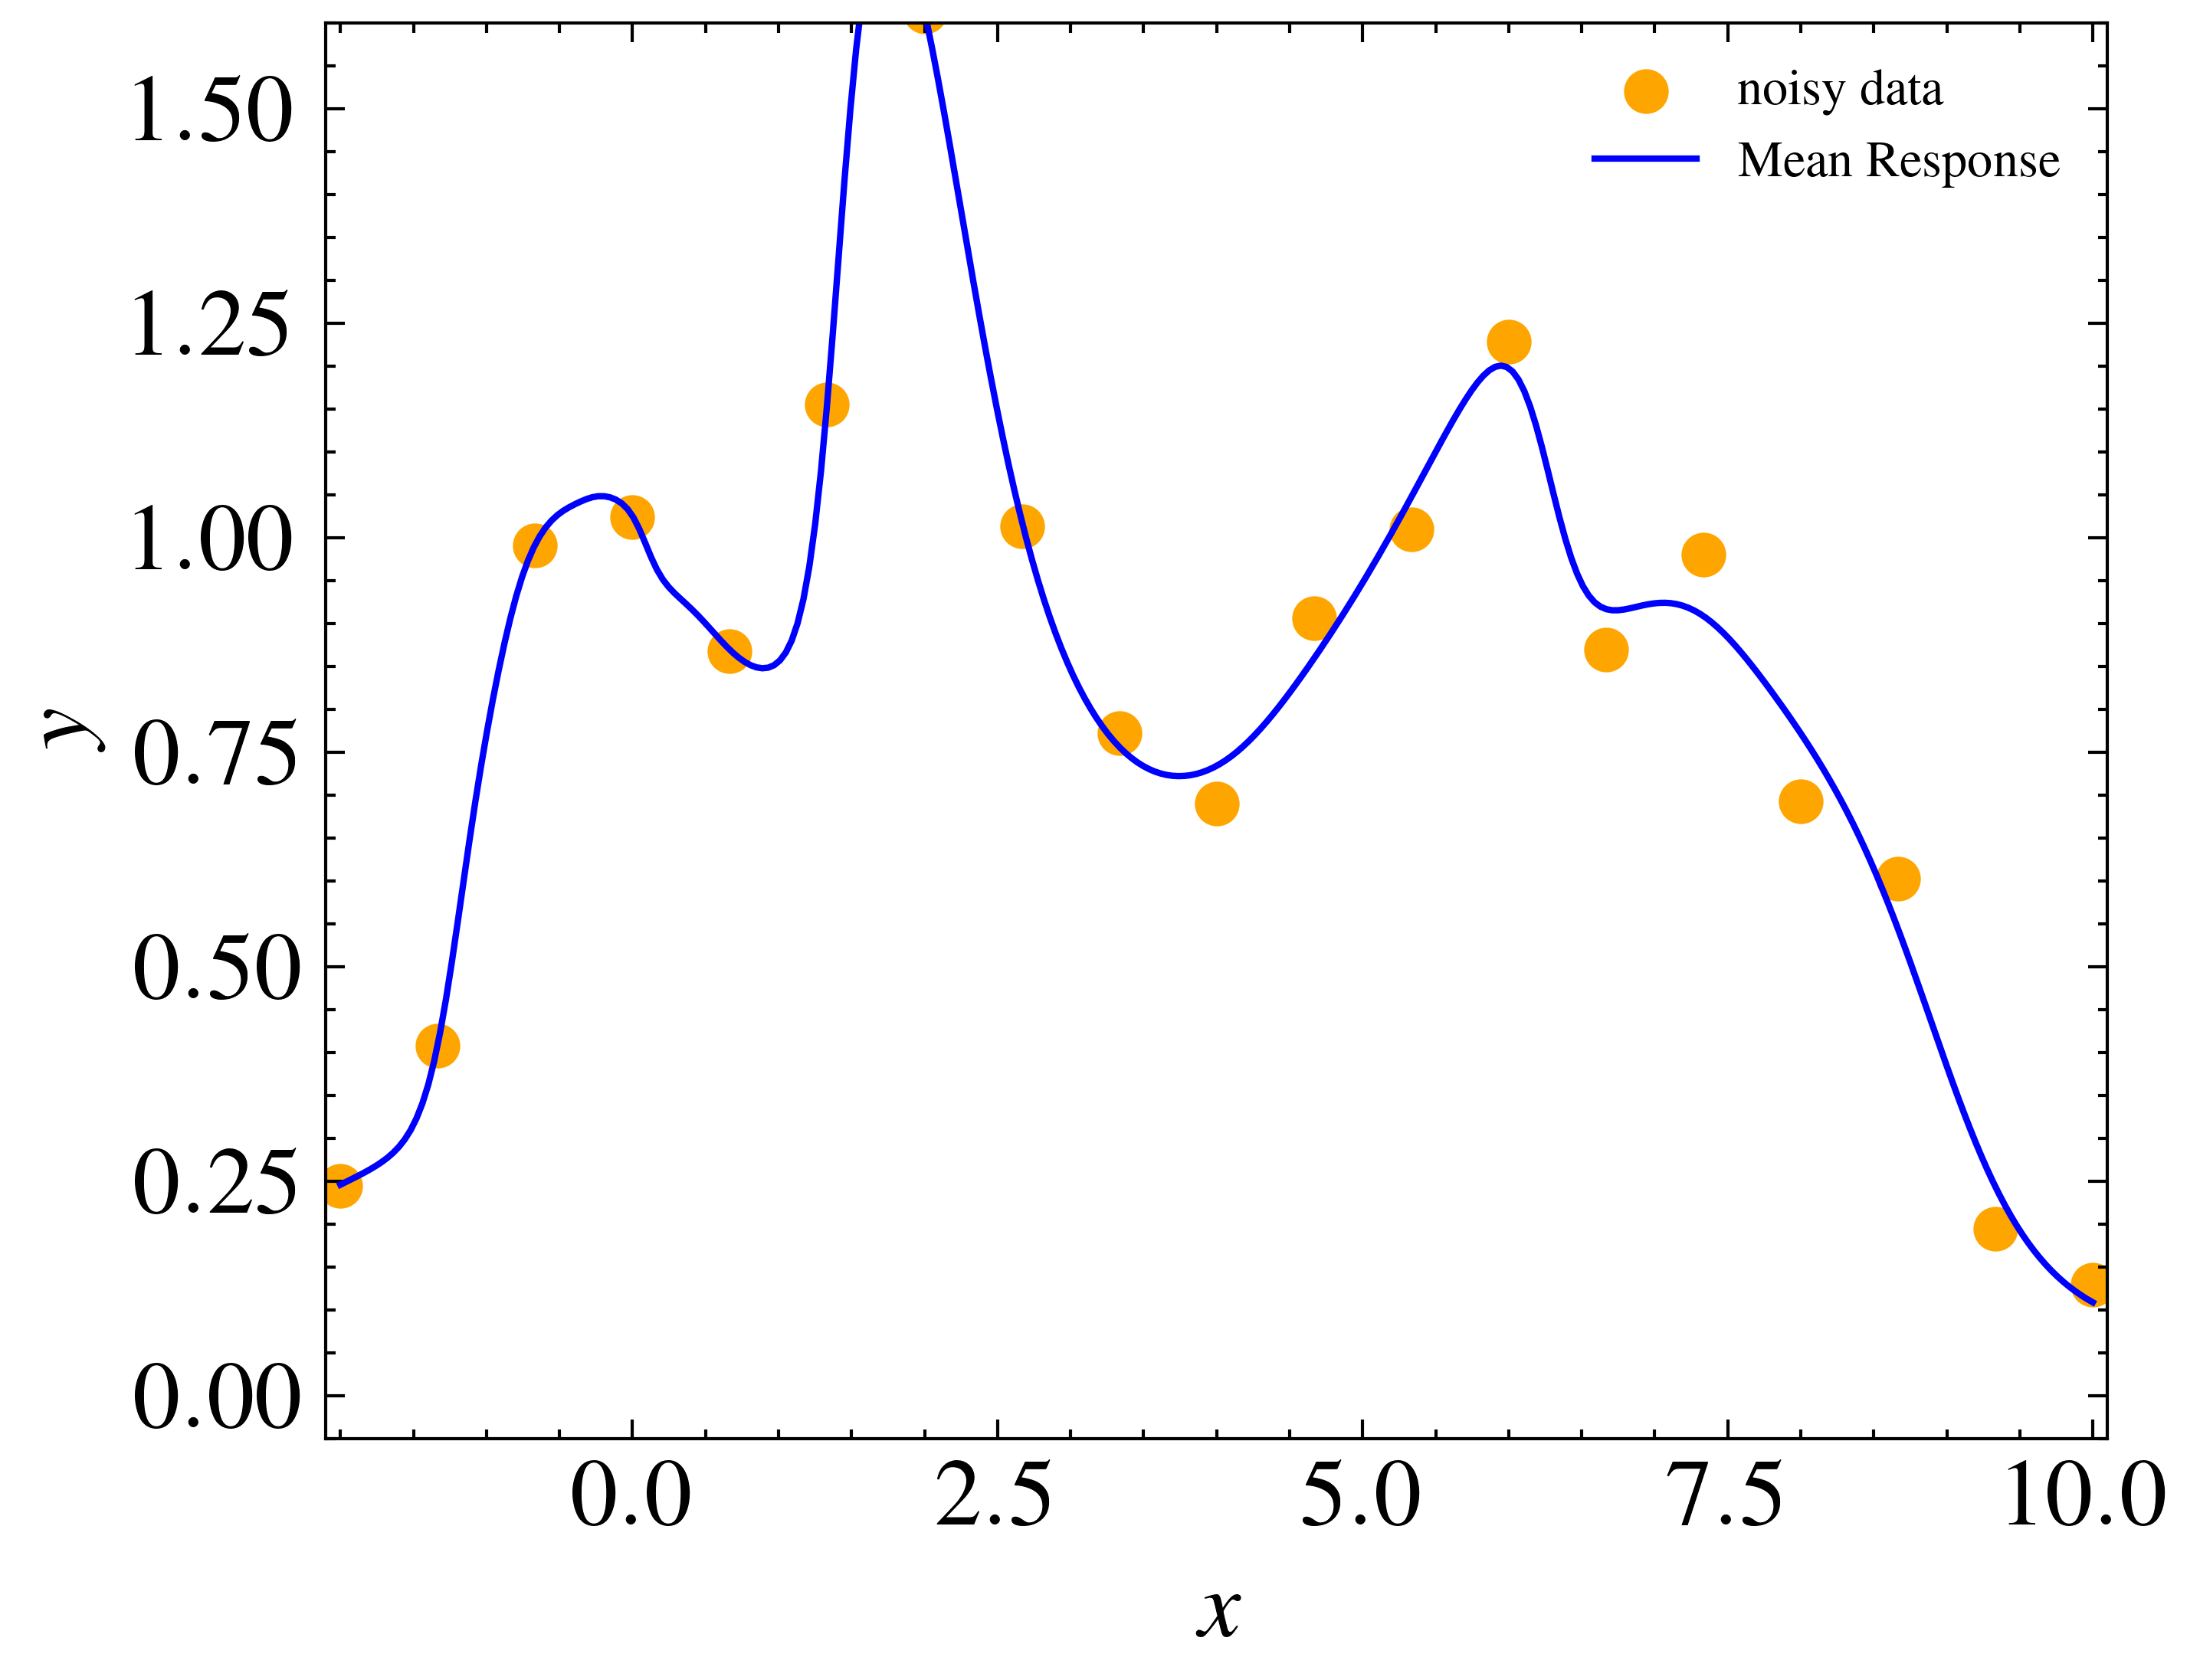

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Configure plot settings
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True
# Generate figure and axis
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_xlim(-2.1, 10.1)
ax.set_ylim(-0.05, 1.6)

# Scatter plot for training set
ax.scatter(x.data.numpy(), ytrain.data.numpy(), color="orange", label='noisy data')

plt.plot(x_respond.numpy(), mean_response, label='Mean Response', color='blue')
plt.legend()
# plt.savefig('D:/PLA2024/Fig2c.eps', format='eps')
plt.show()

In [24]:
# 将 x_respond 和 mean_response 保存到 CSV 文件
x_respond_np = x_respond.numpy()
output_data = np.hstack((x_respond_np, mean_response))
np.savetxt('D:/PycharmProjects/保存的参数/FOrestes（激活函数+noise）mean_response.csv', output_data, delimiter=',', header='x,mean_response', comments='')